**CS 5834, Fall 2020: Intro to Urban Computing Project - K-modes analysis for Gentrification using San Francisco Data Set**




### Imports and Mount File Directories


In [65]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [66]:
import sys
# modify "customized_path_to_homework", path of folder in drive, where you project is stored
customized_path_to_homework = "/content/drive/My Drive/cs5834/urbcomp_fall2020/project"
file_name = "SanFrancisco_typology_output.csv"

sys.path.append(customized_path_to_homework)

In [67]:
%cd $customized_path_to_homework/data

/content/drive/My Drive/cs5834/urbcomp_fall2020/project/data


In [68]:
pip install shap

In [69]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import datetime
import warnings


In [70]:
pip install kmodes

In [71]:
import os
import json
import numpy as np
import pandas as pd
from pandas.io.json import json_normalize
from datetime import datetime 
from tqdm import tqdm
from sklearn.preprocessing import PowerTransformer
import umap
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy import stats

from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes


from lightgbm import LGBMClassifier
import shap
from sklearn.model_selection import cross_val_score

In [72]:

"""
sys.path.insert(0,'../')
%load_ext autoreload
%autoreload 2
import nyctaxi_helpers
warnings.filterwarnings('ignore')
"""

"\nsys.path.insert(0,'../')\n%load_ext autoreload\n%autoreload 2\nimport nyctaxi_helpers\nwarnings.filterwarnings('ignore')\n"

In [73]:
pip install --upgrade mlxtend


Requirement already up-to-date: mlxtend in /usr/local/lib/python3.6/dist-packages (0.18.0)


In [74]:
#ref https://pbpython.com/market-basket-analysis.html


#may need to install mlxtend package - pip install mlxtend in console
import pandas as pd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth
from mlxtend.frequent_patterns import association_rules


# **Process Urban Displacement Model Data for Gentrificaiton**


Reference: https://www.urbandisplacement.org/open-source-project

Based on the work https://ww2.arb.ca.gov/sites/default/files/classic//research/apr/past/13-310.pdf?_ga=2.269282425.968981409.1605209194-851335111.1605209194

**Developing a New
Methodology for Analyzing
Potential Displacement**

University of California, Berkeley

Principal Investigator:
Karen Chapple 

https://ww3.arb.ca.gov/research/single-project.php?row_id=65188

**Obtain the Data**

Data can be found at https://github.com/urban-displacement/displacement-typologies/blob/main/data/outputs/typologies/LosAngeles_typology_output.csv

In [75]:
#!wget -nc https://raw.githubusercontent.com/urban-displacement/displacement-typologies/main/data/outputs/typologies/LosAngeles_typology_output.csv

In [76]:
## Process Data - if data file already processed then can start at Associaton Rules section
# get the Data File

df = pd.read_csv("https://raw.githubusercontent.com/urban-displacement/displacement-typologies/main/data/outputs/typologies/{}".format(file_name), index_col=0)
#df = pd.read_csv("{}/data/{}".format(customized_path_to_homework, file_name), index_col=0)

# sneak peak in the data
df.head(10)


,pop_18,white_18,hh_18,hinc_18,mhval_18,mhval_18_se,mrent_18,mrent_18_se,total_25_18,total_25_col_bd_18,total_25_col_md_18,total_25_col_pd_18,total_25_col_phd_18,tot_units_built_18,units_40_49_built_18,units_39_early_built_18,ohu_18,rhu_18,mmhcosts_18,iinc_18,mov_wc_w_income_18,mov_wc_9000_18,mov_wc_15000_18,mov_wc_25000_18,mov_wc_35000_18,mov_wc_50000_18,mov_wc_65000_18,mov_wc_75000_18,mov_wc_76000_more_18,mov_oc_w_income_18,mov_oc_9000_18,mov_oc_15000_18,mov_oc_25000_18,state_x,county_x,tract_x,mov_oc_35000_18,mov_oc_50000_18,mov_oc_65000_18,mov_oc_75000_18,...,aboverm_pctch_real_mrent_12_18,aboverm_pctch_real_mhval_90_00,aboverm_pctch_real_mrent_90_00,lostli_00,lostli_18,aboverm_pctch_real_hinc_90_00,aboverm_pctch_real_hinc_00_18,aboverm_ch_per_col_90_00,aboverm_ch_per_col_00_18,aboverm_per_units_pre50_18,GEOID,rail,presence_ph_LIHTC,vul_gent_90,vul_gent_00,vul_gent_18,hotmarket_00,hotmarket_18,gent_90_00,gent_90_00_urban,gent_00_18,gent_00_18_urban,dp_PChRent,dp_RentGap,tr_rent_gap,rm_rent_gap,dense,SAE,AdvG,ARE,BE,SMMI,ARG,EOG,OD,OD_loss,LISD,double_counted,typology,typ_cat
0,2772.0,1388.0,1108.0,55125.0,640600.0,36856.0,1185.0,99.0,2014.0,429.0,163.0,70.0,20.0,1222.0,56.0,674.0,349.0,759.0,1211.0,30469.0,458.0,102.0,88.0,23.0,122.0,42.0,42.0,0.0,39.0,19.0,8.0,0.0,0.0,6,55,200202,0.0,7.0,0.0,0.0,...,0,0,1,0,0,1,0,0,1,1,6055200202,0,False,1,1,1,1.0,1.0,0,0,0,0,1,1,332.545513,20.207763,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1.0,1.0,['LISD']
1,4127.0,2874.0,1550.0,100202.0,718900.0,47042.0,1829.0,132.0,2919.0,838.0,264.0,191.0,75.0,1659.0,246.0,249.0,979.0,571.0,1886.0,36140.0,152.0,23.0,29.0,20.0,9.0,0.0,0.0,0.0,71.0,84.0,12.0,12.0,18.0,6,55,200400,13.0,0.0,8.0,0.0,...,1,0,0,0,1,0,1,1,0,1,6055200400,0,False,0,0,0,0.0,1.0,0,0,0,0,1,0,-220.394322,20.207763,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0,0.0,0,1.0,6.0,['SMMI']
2,722.0,396.0,37.0,6953.0,-666666666.0,-222222222.0,394.0,362.0,699.0,42.0,0.0,0.0,0.0,45.0,0.0,0.0,0.0,37.0,394.0,3170.0,24.0,13.0,0.0,0.0,0.0,11.0,0.0,0.0,0.0,61.0,28.0,28.0,5.0,6,55,200900,0.0,0.0,0.0,0.0,...,0,0,1,0,0,0,0,0,0,0,6055200900,0,False,1,1,1,1.0,0.0,0,0,0,0,1,1,1221.590988,20.207763,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0.0,0,1.0,3.0,['ARG']
3,5070.0,3335.0,2045.0,40733.0,321000.0,38985.0,910.0,131.0,3501.0,964.0,199.0,45.0,28.0,2170.0,150.0,16.0,782.0,1263.0,980.0,27002.0,230.0,119.0,23.0,51.0,0.0,37.0,0.0,0.0,0.0,66.0,35.0,0.0,14.0,6,67,6101,6.0,11.0,0.0,0.0,...,0,0,1,1,0,1,0,0,1,1,6067006101,0,False,1,1,1,1.0,0.0,0,0,0,0,0,1,136.081194,20.207763,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1.0,1.0,['LISD']
4,3338.0,1900.0,1628.0,33194.0,328400.0,35481.0,952.0,47.0,2257.0,474.0,110.0,42.0,0.0,1866.0,63.0,97.0,369.0,1259.0,982.0,23330.0,448.0,70.0,137.0,118.0,22.0,29.0,41.0,21.0,10.0,91.0,15.0,0.0,11.0,6,67,6102,36.0,22.0,0.0,0.0,...,0,1,1,0,1,1,0,0,0,1,6067006102,0,False,1,1,1,1.0,0.0,0,0,0,0,0,1,104.694758,20.207763,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1.0,0,1.0,2.0,['OD']
5,4626.0,1591.0,2057.0,27663.0,275900.0,56460.0,826.0,69.0,2933.0,277.0,207.0,132.0,77.0,2315.0,345.0,552.0,671.0,1386.0,842.0,17888.0,532.0,218.0,143.0,120.0,0.0,10.0,20.0,0.0,21.0,252.0,78.0,59.0,73.0,6,67,6900,1.0,1.0,24.0,0.0,...,0,0,0,0,0,0,0,0,0,1,6067006900,1,True,1,1,1,0.0,1.0,0,0,0,0,1,1,263.305617,20.207763,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1.0,1.0,['LISD']
6,2450.0,2123.0,929.0,54745.0,316000.0,25676.0,1124.0,65.0,1646.0,279.0,98.0,36.0,11.0,983.0,9.0,11.0,377.0,552.0,1229.0,29024.0,163.0,55.0,28.0,20.0,16.0,5.0,0.0,0.0,39.0,48.0,7.0,0.0,15.0,6,67,8137,14.0,0.0,0.0,6.0,...,0,1,1,0,0,1,0,0,0,0,6067008137,0,True,1,1,1,1.0,0.0,0,0,0,0,1,1,92.135407,20.207763,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,1,1.0,1.0,['LISD']
7,5908.0,4764.0,2692.0,94853.0,495900.0,55770.0,1473.0,153.0,4672.0,1088.0,585.0,207.0,135.0,2707.0,17.0,70.0,2182.0,510.0,1623.0,50724.0,271.0,53.0,23.0,63.0,34.0,15.0,15.0,0.0,68.0,147.0,62.0,1.0,17.0,6,67,8210,0.0,0.0,32.0,0.0,...,0,0,0,0,0,0,0,0,0,0,6067008210,0,False,0,0,0,0.0,0.0,0,0,0,0,0,1,46.749801,20.207763,0,0.0,0.0,1.0,0

In [77]:
df.columns

Index(['pop_18', 'white_18', 'hh_18', 'hinc_18', 'mhval_18', 'mhval_18_se',
       'mrent_18', 'mrent_18_se', 'total_25_18', 'total_25_col_bd_18',
       ...
       'BE', 'SMMI', 'ARG', 'EOG', 'OD', 'OD_loss', 'LISD', 'double_counted',
       'typology', 'typ_cat'],
      dtype='object', length=305)

In [78]:
"""
# create a working copy of the data to process
df2 = df.copy()

#removed  'inc_cat_medhhinc_encoded18', 'inc_cat_medhhinc_encoded00',
df2 = df2[[ 'inc80_18',
 'inc120_18',
 'inc80_00',
 'inc120_00',
 'inc80_90',
 'low_80120_18',
 'mod_80120_18',
 'high_80120_18',
 'low_pdmt_medhhinc_18',
 'high_pdmt_medhhinc_18',
 'mod_pdmt_medhhinc_18',
 'mix_low_medhhinc_18',
 'mix_mod_medhhinc_18',
 'mix_high_medhhinc_18',

 'low_80120_00',
 'mod_80120_00',
 'high_80120_00',
 'low_pdmt_medhhinc_00',
 'high_pdmt_medhhinc_00',
 'mod_pdmt_medhhinc_00',
 'mix_low_medhhinc_00',
 'mix_mod_medhhinc_00',
 'mix_high_medhhinc_00',

 'per_all_li_90',
 'per_all_li_00',
 'per_all_li_18',
 'per_nonwhite_90',
 'per_nonwhite_00',
 'per_nonwhite_18',
 'per_rent_90',
 'per_rent_00',
 'per_rent_18',
 'per_col_90',
 'per_col_00',
 'per_col_18',
 'per_units_pre50_18',
 'per_limove_18',
 'per_limove_12',
 'lmh_flag_category',
 'pctch_real_mhval_00_18',
 'pctch_real_mrent_12_18',
 'rent_decrease',
 'rent_marginal',
 'rent_increase',
 'rent_rapid_increase',
 'house_decrease',
 'house_marginal',
 'house_increase',
 'house_rapid_increase',
 'tot_decrease',
 'tot_marginal',
 'tot_increase',
 'tot_rapid_increase',
 'change_flag_category',
 'per_ch_zillow_12_18',
 'ab_50pct_ch',
 'ab_90percentile_ch',
 'rent_50pct_ch',
 'rent_90percentile_ch',
 'hv_abrm_ch',
 'rent_abrm_ch',
 'pctch_real_mhval_90_00',
 'pctch_real_mrent_90_00',
 'pctch_real_hinc_90_00',
 'pctch_real_mrent_00_18',
 'pctch_real_hinc_00_18',
 'ch_per_col_90_00',
 'ch_per_col_00_18',
 'ch_per_limove_12_18',
 'aboverm_per_all_li_90',
 'aboverm_per_all_li_00',
 'aboverm_per_all_li_18',
 'aboverm_per_nonwhite_18',
 'aboverm_per_nonwhite_90',
 'aboverm_per_nonwhite_00',
 'aboverm_per_rent_90',
 'aboverm_per_rent_00',
 'aboverm_per_rent_18',
 'aboverm_per_col_90',
 'aboverm_per_col_00',
 'aboverm_per_col_18',
 'aboverm_real_mrent_90',
 'aboverm_real_mrent_00',
 'aboverm_real_mrent_12',
 'aboverm_real_mrent_18',
 'aboverm_real_mhval_90',
 'aboverm_real_mhval_00',
 'aboverm_real_mhval_18',
 'aboverm_pctch_real_mhval_00_18',
 'aboverm_pctch_real_mrent_00_18',
 'aboverm_pctch_real_mrent_12_18',
 'aboverm_pctch_real_mhval_90_00',
 'aboverm_pctch_real_mrent_90_00',
 'lostli_00',
 'lostli_18',
 'aboverm_pctch_real_hinc_90_00',
 'aboverm_pctch_real_hinc_00_18',
 'aboverm_ch_per_col_90_00',
 'aboverm_ch_per_col_00_18',
 'aboverm_per_units_pre50_18',
 'GEOID',
 'rail',
 'presence_ph_LIHTC',
 'hotmarket_00',
 'hotmarket_18',
 'dp_PChRent',
 'dp_RentGap',
 'dense',
 'typology']]


# drop rows which dont have a gentrification category
df2.dropna(subset=['typology'], inplace=True)
df2 = df2.set_index('GEOID')

#fill the nas
df2.fillna(0.0, inplace=True)


df2.head(10)
"""

"\n# create a working copy of the data to process\ndf2 = df.copy()\n\n#removed  'inc_cat_medhhinc_encoded18', 'inc_cat_medhhinc_encoded00',\ndf2 = df2[[ 'inc80_18',\n 'inc120_18',\n 'inc80_00',\n 'inc120_00',\n 'inc80_90',\n 'low_80120_18',\n 'mod_80120_18',\n 'high_80120_18',\n 'low_pdmt_medhhinc_18',\n 'high_pdmt_medhhinc_18',\n 'mod_pdmt_medhhinc_18',\n 'mix_low_medhhinc_18',\n 'mix_mod_medhhinc_18',\n 'mix_high_medhhinc_18',\n\n 'low_80120_00',\n 'mod_80120_00',\n 'high_80120_00',\n 'low_pdmt_medhhinc_00',\n 'high_pdmt_medhhinc_00',\n 'mod_pdmt_medhhinc_00',\n 'mix_low_medhhinc_00',\n 'mix_mod_medhhinc_00',\n 'mix_high_medhhinc_00',\n\n 'per_all_li_90',\n 'per_all_li_00',\n 'per_all_li_18',\n 'per_nonwhite_90',\n 'per_nonwhite_00',\n 'per_nonwhite_18',\n 'per_rent_90',\n 'per_rent_00',\n 'per_rent_18',\n 'per_col_90',\n 'per_col_00',\n 'per_col_18',\n 'per_units_pre50_18',\n 'per_limove_18',\n 'per_limove_12',\n 'lmh_flag_category',\n 'pctch_real_mhval_00_18',\n 'pctch_real_mrent_1

In [79]:
# create a working copy of the data to process
df2 = df.copy()

"""
removed  'inc_cat_medhhinc_encoded18', 'inc_cat_medhhinc_encoded00', 
'inc80_18',
 'inc120_18',
 'inc80_00',
 'inc120_00',
 'inc80_90',
  'per_col_90',
 'per_col_00',
 'per_col_18',
  'tot_decrease',
 'tot_marginal',
 'tot_increase',
 'tot_rapid_increase',
  'pctch_real_mhval_90_00',
 'pctch_real_mrent_90_00',
 'pctch_real_mrent_00_18',
 'per_units_pre50_18',
  
"""

df2.head(10)
df2 = df2[[ 

 'low_80120_18',
 'mod_80120_18',
 'high_80120_18',
 'low_pdmt_medhhinc_18',
 'high_pdmt_medhhinc_18',
 'mod_pdmt_medhhinc_18',
 'mix_low_medhhinc_18',
 'mix_mod_medhhinc_18',
 'mix_high_medhhinc_18',

 'low_80120_00',
 'mod_80120_00',
 'high_80120_00',
 'low_pdmt_medhhinc_00',
 'high_pdmt_medhhinc_00',
 'mod_pdmt_medhhinc_00',
 'mix_low_medhhinc_00',
 'mix_mod_medhhinc_00',
 'mix_high_medhhinc_00',

 'per_all_li_90',
 'per_all_li_00',
 'per_all_li_18',
 'per_nonwhite_90',
 'per_nonwhite_00',
 'per_nonwhite_18',
 'per_rent_90',
 'per_rent_00',
 'per_rent_18',

 
 'per_limove_18',
 'per_limove_12',
 'lmh_flag_category',
 'pctch_real_mhval_00_18',
 'pctch_real_mrent_12_18',
 'rent_decrease',
 'rent_marginal',
 'rent_increase',
 'rent_rapid_increase',
 'house_decrease',
 'house_marginal',
 'house_increase',
 'house_rapid_increase',

 'change_flag_category',
 'per_ch_zillow_12_18',
 'ab_50pct_ch',
 'ab_90percentile_ch',
 'rent_50pct_ch',
 'rent_90percentile_ch',
 'hv_abrm_ch',
 'rent_abrm_ch',

 'pctch_real_hinc_90_00',
 
 'pctch_real_hinc_00_18',
 'ch_per_col_90_00',
 'ch_per_col_00_18',
 'ch_per_limove_12_18',
 'aboverm_per_all_li_90',
 'aboverm_per_all_li_00',
 'aboverm_per_all_li_18',
 'aboverm_per_nonwhite_18',
 'aboverm_per_nonwhite_90',
 'aboverm_per_nonwhite_00',
 'aboverm_per_rent_90',
 'aboverm_per_rent_00',
 'aboverm_per_rent_18',
 'aboverm_per_col_90',
 'aboverm_per_col_00',
 'aboverm_per_col_18',
 'aboverm_real_mrent_90',
 'aboverm_real_mrent_00',
 'aboverm_real_mrent_12',
 'aboverm_real_mrent_18',
 'aboverm_real_mhval_90',
 'aboverm_real_mhval_00',
 'aboverm_real_mhval_18',
 'aboverm_pctch_real_mhval_00_18',
 'aboverm_pctch_real_mrent_00_18',
 'aboverm_pctch_real_mrent_12_18',
 'aboverm_pctch_real_mhval_90_00',
 'aboverm_pctch_real_mrent_90_00',
 'lostli_00',
 'lostli_18',
 'aboverm_pctch_real_hinc_90_00',
 'aboverm_pctch_real_hinc_00_18',
 'aboverm_ch_per_col_90_00',
 'aboverm_ch_per_col_00_18',
 'aboverm_per_units_pre50_18',
 'GEOID',
 'rail',
 'presence_ph_LIHTC',
 'hotmarket_00',
 'hotmarket_18',
 'dp_PChRent',
 'dp_RentGap',
 'dense',
 'typology']]

# drop rows which dont have a gentrification category
df2.dropna(subset=['typology'], inplace=True)
df2 = df2.set_index('GEOID')

#fill the nas
df2.fillna(0.0, inplace=True)


df2.head(10)

,low_80120_18,mod_80120_18,high_80120_18,low_pdmt_medhhinc_18,high_pdmt_medhhinc_18,mod_pdmt_medhhinc_18,mix_low_medhhinc_18,mix_mod_medhhinc_18,mix_high_medhhinc_18,low_80120_00,mod_80120_00,high_80120_00,low_pdmt_medhhinc_00,high_pdmt_medhhinc_00,mod_pdmt_medhhinc_00,mix_low_medhhinc_00,mix_mod_medhhinc_00,mix_high_medhhinc_00,per_all_li_90,per_all_li_00,per_all_li_18,per_nonwhite_90,per_nonwhite_00,per_nonwhite_18,per_rent_90,per_rent_00,per_rent_18,per_limove_18,per_limove_12,lmh_flag_category,pctch_real_mhval_00_18,pctch_real_mrent_12_18,rent_decrease,rent_marginal,rent_increase,rent_rapid_increase,house_decrease,house_marginal,house_increase,house_rapid_increase,...,ch_per_limove_12_18,aboverm_per_all_li_90,aboverm_per_all_li_00,aboverm_per_all_li_18,aboverm_per_nonwhite_18,aboverm_per_nonwhite_90,aboverm_per_nonwhite_00,aboverm_per_rent_90,aboverm_per_rent_00,aboverm_per_rent_18,aboverm_per_col_90,aboverm_per_col_00,aboverm_per_col_18,aboverm_real_mrent_90,aboverm_real_mrent_00,aboverm_real_mrent_12,aboverm_real_mrent_18,aboverm_real_mhval_90,aboverm_real_mhval_00,aboverm_real_mhval_18,aboverm_pctch_real_mhval_00_18,aboverm_pctch_real_mrent_00_18,aboverm_pctch_real_mrent_12_18,aboverm_pctch_real_mhval_90_00,aboverm_pctch_real_mrent_90_00,lostli_00,lostli_18,aboverm_pctch_real_hinc_90_00,aboverm_pctch_real_hinc_00_18,aboverm_ch_per_col_90_00,aboverm_ch_per_col_00_18,aboverm_per_units_pre50_18,rail,presence_ph_LIHTC,hotmarket_00,hotmarket_18,dp_PChRent,dp_RentGap,dense,typology
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6055200202,0.656685,0.119309,0.224006,1.0,0.0,0.0,0.0,0.0,0.0,0.598476,0.213825,0.187699,1.0,0.0,0.0,0.0,0.0,0.0,0.359888,0.598476,0.656685,0.268828,0.374460,0.499278,0.601592,0.744068,0.685018,0.601739,0.805837,aff_predominantly_LI,0.964772,0.110892,0,0,1,0,0,0,0,1,...,-0.204098,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,1,0,0,1,1,0,False,1.0,1.0,1,1,0,1.0
6055200400,0.321536,0.220092,0.458372,0.0,0.0,0.0,0.0,1.0,0.0,0.371460,0.188292,0.440248,0.0,0.0,0.0,0.0,1.0,0.0,0.320731,0.371460,0.321536,0.101516,0.151776,0.303610,0.323834,0.330153,0.368387,0.515521,0.225764,aff_mix_mod,0.700576,0.186283,0,0,1,0,0,0,0,1,...,0.289757,1,1,0,0,0,0,0,0,0,1,1,1,1,0,1,1,1,1,1,0,1,1,0,0,0,1,0,1,1,0,1,0,False,0.0,1.0,1,0,0,6.0
6055200900,0.810811,0.189189,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,1.000000,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.810811,0.337079,0.443431,0.451524,1.000000,1.000000,1.000000,0.870588,0.951613,aff_mix_low,-inf,-0.565539,1,0,0,0,1,0,0,0,...,-0.081025,0,0,1,0,1,1,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,False,1.0,0.0,1,1,0,3.0
6067006101,0.748241,0.084786,0.166973,1.0,0.0,0.0,0.0,0.0,0.0,0.556107,0.193411,0.250482,1.0,0.0,0.0,0.0,0.0,0.0,0.623286,0.556107,0.748241,0.141847,0.314462,0.342209,0.610216,0.527879,0.617604,0.814583,0.679512,aff_predominantly_LI,0.493266,0.048363,0,1,0,0,0,0,1,0,...,0.135071,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,1,1,0,False,1.0,0.0,0,1,0,1.0
6067006102,0.764552,0.110582,0.124866,1.0,0.0,0.0,0.0,0.0,0.0,0.681812,0.130500,0.187688,1.0,0.0,0.0,0.0,0.0,0.0,0.324958,0.681812,0.764552,0.141847,0.256373,0.430797,0.610216,0.744882,0.773342,0.688130,0.706292,aff_predominantly_LI,0.216783,-0.016448,0,1,0,0,0,0,1,0,...,-0.018162,1,1,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1,0,0,0,1,0,False,1.0,0.0,0,1,0,2.0
6067006900,0.857817,0.053220,0.088962,1.0,0.0,0.0,0.0,0.0,0.0,0.678921,0.145489,0.175589,1.0,0.0,0.0,0.0,0.0,0.0,0.631138,0.678921,0.857817,0.283795,0.489423,0.656074,0.565137,0.602141,0.673797,0.883412,0.756344,aff_predominantly_LI,0.951589,-0.010447,0,1,0,0,0,0,0,1,...,0.127068,1,1,1,1,0,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,True,0.0,1.0,1,1,0,1.0
6067008137,0.632070,0.176806,0.191124,1.0,0.0,0.0,0.0,0.0,0.0,0.429268,0.267406,0.303325,0.0,0.0,0.0,0.0,1.0,0.0,0.353711,0.429268,0.632070,0.131252,0.176129,0.133469,0.563120,0.532099,0.594187,0.711744,0.581250,af

scratch cells to check data cleanup

In [80]:
df2['pctch_real_mhval_00_18'] = df2['pctch_real_mhval_00_18'].replace([np.inf, -np.inf], np.nan)


In [81]:
df2['pctch_real_mhval_00_18'].describe()

count    2.053000e+03
mean    -9.684664e+02
std      4.014541e+04
min     -1.816774e+06
25%      3.364823e-01
50%      5.018036e-01
75%      8.208063e-01
max      2.298270e+03
Name: pctch_real_mhval_00_18, dtype: float64

In [82]:
df2['pctch_real_hinc_90_00'] = df2['pctch_real_hinc_90_00'].replace([np.inf, -np.inf], np.nan)

In [83]:
df2['pctch_real_hinc_90_00'].describe()

count     2063.000000
mean         6.004155
std        227.974937
min         -0.902334
25%          0.014333
50%          0.149517
75%          0.470080
max      10353.121259
Name: pctch_real_hinc_90_00, dtype: float64

In [84]:
# change 99 typology to 10 to facilitate graphing by typology
df2['typology'] = df2['typology'].replace([99], 10)

In [85]:
# orginal dataset counts 
df2['typology'].value_counts()

6.0     668
1.0     516
7.0     339
9.0     229
3.0      89
8.0      80
5.0      50
2.0      48
10.0     25
4.0      20
Name: typology, dtype: int64

Correlation Heatmap

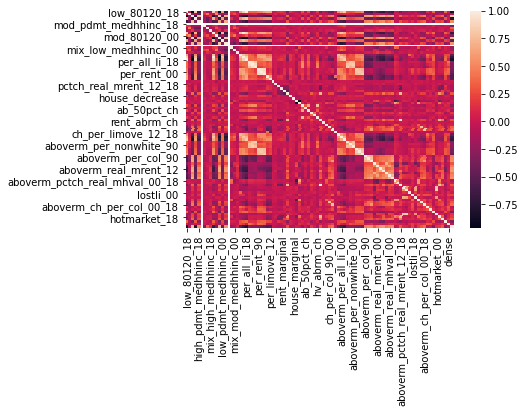

In [86]:
import seaborn as sns

sns.heatmap(df2.corr())

In [87]:
#df2.corr()['inc80_18'] > 0.9


In [88]:
#ref: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

# Create correlation matrix
corr_matrix = df2.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

In [89]:
to_drop

['high_80120_18',
 'high_80120_00',
 'per_all_li_00',
 'per_all_li_18',
 'aboverm_pctch_real_mrent_12_18']

In [90]:
# Drop features 
#df2.drop(df[to_drop], axis=1)

### Convert select continous variables to categorical and one hot encode 

In [91]:
"""
# convert already dummy variables from float to int
dummy_var_list = ['hotmarket_00', 'hotmarket_18', 'low_pdmt_medhhinc_00', 'high_pdmt_medhhinc_00', 'mod_pdmt_medhhinc_00',
                  'mix_low_medhhinc_00', 'mix_mod_medhhinc_00',  'mix_high_medhhinc_00', 'low_pdmt_medhhinc_18', 'high_pdmt_medhhinc_18',
                  'mod_pdmt_medhhinc_18', 'mix_low_medhhinc_18', 'mix_mod_medhhinc_18', 'mix_high_medhhinc_18', 'presence_ph_LIHTC',
                  'typology']
for dummycol in dummy_var_list:
  df2.loc[:,(dummycol)] = df2[dummycol].astype(int, copy=False)
"""

"\n# convert already dummy variables from float to int\ndummy_var_list = ['hotmarket_00', 'hotmarket_18', 'low_pdmt_medhhinc_00', 'high_pdmt_medhhinc_00', 'mod_pdmt_medhhinc_00',\n                  'mix_low_medhhinc_00', 'mix_mod_medhhinc_00',  'mix_high_medhhinc_00', 'low_pdmt_medhhinc_18', 'high_pdmt_medhhinc_18',\n                  'mod_pdmt_medhhinc_18', 'mix_low_medhhinc_18', 'mix_mod_medhhinc_18', 'mix_high_medhhinc_18', 'presence_ph_LIHTC',\n                  'typology']\nfor dummycol in dummy_var_list:\n  df2.loc[:,(dummycol)] = df2[dummycol].astype(int, copy=False)\n"

In [92]:
"""
# use float variables to represent each categorical variable by dividing into quartiles
def convert_percents_to_dummy_vars(X):

    columns = X.columns

    bin_labels_4 = ['VL', 'L', 'H',  'VH']


    for i in range(0, len(columns)):
        if X[columns[i]].dtype=='float64':
          print("Processing: " + columns[i])

          X[columns[i]] = X[columns[i]].fillna(0)
          cat_label = "{}_cat".format(columns[i])
          dummy_label = "{}_dummy".format(columns[i])
          X[cat_label] = pd.qcut(X[columns[i]], 
                                 4,
                              precision=5,
                              duplicates = 'drop',
                              labels=bin_labels_4)
          X = pd.get_dummies(X, columns=[cat_label], prefix=[dummy_label])
          X = X.drop([columns[i]], axis=1)

    return X
"""

'\n# use float variables to represent each categorical variable by dividing into quartiles\ndef convert_percents_to_dummy_vars(X):\n\n    columns = X.columns\n\n    bin_labels_4 = [\'VL\', \'L\', \'H\',  \'VH\']\n\n\n    for i in range(0, len(columns)):\n        if X[columns[i]].dtype==\'float64\':\n          print("Processing: " + columns[i])\n\n          X[columns[i]] = X[columns[i]].fillna(0)\n          cat_label = "{}_cat".format(columns[i])\n          dummy_label = "{}_dummy".format(columns[i])\n          X[cat_label] = pd.qcut(X[columns[i]], \n                                 4,\n                              precision=5,\n                              duplicates = \'drop\',\n                              labels=bin_labels_4)\n          X = pd.get_dummies(X, columns=[cat_label], prefix=[dummy_label])\n          X = X.drop([columns[i]], axis=1)\n\n    return X\n'

In [93]:
"""
# check if categorical then convert to dummy using label and onehot encoding
def convert_categorical_to_dummy_vars(X):

    from sklearn.preprocessing import LabelEncoder
    from sklearn.preprocessing import OneHotEncoder    

    columns = X.columns
    indices = X.index
    new_columns = []
    encoded_x = None

    for i in range(0, len(columns)):
        if X[columns[i]].dtype=='O':
          print("Processing: " + columns[i])


          label_encoder = LabelEncoder()
          le = label_encoder.fit(X[columns[i]].apply(str))
          for class_ in le.classes_:
              new_columns.append("{}_{}".format(columns[i],class_))
              
          feature = le.transform(X[columns[i]].apply(str))
          feature = feature.reshape(X.shape[0], 1)
          onehot_encoder = OneHotEncoder(sparse=False)
          onehot_encoder.fit(feature)
          feature = onehot_encoder.transform(feature)
          if encoded_x is None:
              encoded_x = feature
          else:
              encoded_x = np.concatenate((encoded_x, feature), axis=1)
          X = X.drop(columns[i], axis=1)
    new_columns.extend(X.columns)

    X = pd.DataFrame(np.concatenate((encoded_x,X),axis=1),index=indices,columns=new_columns)
    
    return X
  """

'\n# check if categorical then convert to dummy using label and onehot encoding\ndef convert_categorical_to_dummy_vars(X):\n\n    from sklearn.preprocessing import LabelEncoder\n    from sklearn.preprocessing import OneHotEncoder    \n\n    columns = X.columns\n    indices = X.index\n    new_columns = []\n    encoded_x = None\n\n    for i in range(0, len(columns)):\n        if X[columns[i]].dtype==\'O\':\n          print("Processing: " + columns[i])\n\n\n          label_encoder = LabelEncoder()\n          le = label_encoder.fit(X[columns[i]].apply(str))\n          for class_ in le.classes_:\n              new_columns.append("{}_{}".format(columns[i],class_))\n              \n          feature = le.transform(X[columns[i]].apply(str))\n          feature = feature.reshape(X.shape[0], 1)\n          onehot_encoder = OneHotEncoder(sparse=False)\n          onehot_encoder.fit(feature)\n          feature = onehot_encoder.transform(feature)\n          if encoded_x is None:\n              encoded


### Convert Percentage (floats) to Quartiles and Dummy Variables 

In [94]:
"""
# process and save data all converted to one hot encoding
df2 = convert_percents_to_dummy_vars(df2)


"""


'\n# process and save data all converted to one hot encoding\ndf2 = convert_percents_to_dummy_vars(df2)\n\n\n'

In [95]:
"""
df2 = convert_categorical_to_dummy_vars(df2)
"""

'\ndf2 = convert_categorical_to_dummy_vars(df2)\n'

UMAP Embedding

One of the comparison methods will be visual, so we need a way to visualise the quality of clustering. I'll be using Uniform Manifold Approximation and Projection for Dimension Reduction (UMAP) - a dimensionality reduction technique (like PCA or t-SNE) - to embedd the data into 2 dimensions. This will allow me to visually see the groups of customers, and how well did the clustering algorithms do the job. There are 3 steps to get the proper embeddings:

Yeo-Johnson transform the numerical columns & One-Hot-Encode the categorical data

Embed these two column types separately

Combine the two by conditioning the numerical embeddings on the categorical embeddings as suggested here

In [96]:
full_data = df2

In [97]:
#ref: https://antonsruberts.github.io/kproto-audience/
#Preprocessing numerical
numerical = full_data.select_dtypes(exclude='object')

for c in numerical.columns:
    print("Processing: {}".format(c))
    
    pt = PowerTransformer()
    numerical.loc[:, c] = pt.fit_transform(np.array(numerical[c]).reshape(-1, 1))
    
##preprocessing categorical
categorical = full_data.select_dtypes(include='object')
categorical = pd.get_dummies(categorical)

#Percentage of columns which are categorical is used as weight parameter in embeddings later
categorical_weight = len(full_data.select_dtypes(include='object').columns) / full_data.shape[1]

numerical = numerical.replace([np.inf, -np.inf, np.NaN], 0)
#Embedding numerical & categorical
fit1 = umap.UMAP(metric='l2').fit(numerical)
fit2 = umap.UMAP(metric='dice').fit(categorical)



Processing: low_80120_18
Processing: mod_80120_18
Processing: high_80120_18
Processing: low_pdmt_medhhinc_18
Processing: high_pdmt_medhhinc_18
Processing: mod_pdmt_medhhinc_18
Processing: mix_low_medhhinc_18
Processing: mix_mod_medhhinc_18
Processing: mix_high_medhhinc_18
Processing: low_80120_00
Processing: mod_80120_00
Processing: high_80120_00
Processing: low_pdmt_medhhinc_00
Processing: high_pdmt_medhhinc_00
Processing: mod_pdmt_medhhinc_00
Processing: mix_low_medhhinc_00
Processing: mix_mod_medhhinc_00
Processing: mix_high_medhhinc_00
Processing: per_all_li_90
Processing: per_all_li_00
Processing: per_all_li_18
Processing: per_nonwhite_90
Processing: per_nonwhite_00
Processing: per_nonwhite_18
Processing: per_rent_90
Processing: per_rent_00



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Processing: per_rent_18
Processing: per_limove_18
Processing: per_limove_12
Processing: pctch_real_mhval_00_18
Processing: pctch_real_mrent_12_18
Processing: rent_decrease
Processing: rent_marginal
Processing: rent_increase
Processing: rent_rapid_increase
Processing: house_decrease
Processing: house_marginal
Processing: house_increase
Processing: house_rapid_increase
Processing: per_ch_zillow_12_18
Processing: ab_50pct_ch
Processing: ab_90percentile_ch
Processing: rent_50pct_ch
Processing: rent_90percentile_ch
Processing: hv_abrm_ch
Processing: rent_abrm_ch
Processing: pctch_real_hinc_90_00
Processing: pctch_real_hinc_00_18
Processing: ch_per_col_90_00



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Processing: ch_per_col_00_18
Processing: ch_per_limove_12_18
Processing: aboverm_per_all_li_90
Processing: aboverm_per_all_li_00
Processing: aboverm_per_all_li_18
Processing: aboverm_per_nonwhite_18
Processing: aboverm_per_nonwhite_90
Processing: aboverm_per_nonwhite_00
Processing: aboverm_per_rent_90
Processing: aboverm_per_rent_00
Processing: aboverm_per_rent_18
Processing: aboverm_per_col_90
Processing: aboverm_per_col_00
Processing: aboverm_per_col_18
Processing: aboverm_real_mrent_90
Processing: aboverm_real_mrent_00
Processing: aboverm_real_mrent_12
Processing: aboverm_real_mrent_18
Processing: aboverm_real_mhval_90
Processing: aboverm_real_mhval_00



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

Processing: aboverm_real_mhval_18
Processing: aboverm_pctch_real_mhval_00_18
Processing: aboverm_pctch_real_mrent_00_18
Processing: aboverm_pctch_real_mrent_12_18
Processing: aboverm_pctch_real_mhval_90_00
Processing: aboverm_pctch_real_mrent_90_00
Processing: lostli_00
Processing: lostli_18
Processing: aboverm_pctch_real_hinc_90_00
Processing: aboverm_pctch_real_hinc_00_18
Processing: aboverm_ch_per_col_90_00
Processing: aboverm_ch_per_col_00_18
Processing: aboverm_per_units_pre50_18
Processing: rail
Processing: presence_ph_LIHTC
Processing: hotmarket_00
Processing: hotmarket_18
Processing: dp_PChRent
Processing: dp_RentGap
Processing: dense
Processing: typology



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [98]:
categorical_weight

0.021739130434782608

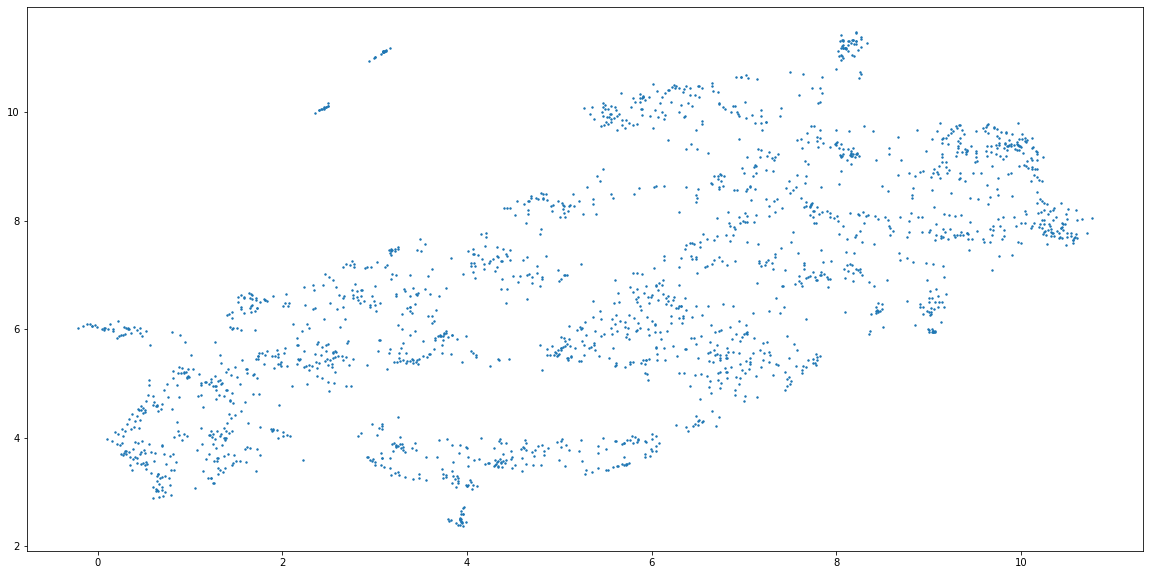

In [99]:
#Augmenting the numerical embedding with categorical
intersection = umap.umap_.general_simplicial_set_intersection(fit1.graph_, fit2.graph_, weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(fit1._raw_data, intersection, fit1.n_components, 
                                                fit1._initial_alpha, fit1._a, fit1._b, 
                                                fit1.repulsion_strength, fit1.negative_sample_rate, 
                                                200, 'random', np.random, fit1.metric, 
                                                fit1._metric_kwds, False)

plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

KMeans with OHE

Because K-Means only works with numerical data, I'll:

One-Hot-Encode the categorical data
Apply the Yeo-Johnson transformation to the data to make it more Gaussian like
Fit K-Means with 15 clusters

In [100]:
data = pd.get_dummies(full_data)
for c in data.columns:
    pt = PowerTransformer()
    data.loc[:, c] = pt.fit_transform(np.array(data[c]).reshape(-1, 1))

divide by zero encountered in log
divide by zero encountered in log


In [101]:
data = data.replace([np.inf, -np.inf, np.NaN], 0)

In [102]:
#ref: https://antonsruberts.github.io/kproto-audience/

#Actual Clustering
kmeans = KMeans(n_clusters=10).fit(data)
kmeans_labels = kmeans.labels_



In [103]:
kmeans_labels

array([1, 3, 9, ..., 8, 6, 6], dtype=int32)

In [104]:
pd.Series(kmeans_labels).value_counts()

3    296
2    262
5    256
1    255
4    236
7    229
6    204
0    204
8     94
9     28
dtype: int64

In [105]:
 from sklearn.metrics import confusion_matrix
 

In [106]:
#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

100%|██████████| 48/48 [00:46<00:00,  1.02it/s]


K-prototypes

For K-Prototypes, I'll apply the transformation to numerical data. Categorical data doesn't need any pre-processing.

In [107]:
kprot_data = full_data.copy()
for c in full_data.select_dtypes(exclude='object').columns:
    pt = PowerTransformer()
    kprot_data[c] =  pt.fit_transform(np.array(kprot_data[c]).reshape(-1, 1))

divide by zero encountered in log
divide by zero encountered in log


In [108]:
for c in full_data.select_dtypes(include='object').columns:
  print("Cat column: {} at position {}".format(c,full_data.columns.get_loc(c)))

Cat column: lmh_flag_category at position 29
Cat column: change_flag_category at position 40


In [109]:
categorical_columns = [29,40] #make sure to specify correct indices

In [110]:
kprot_data = kprot_data.replace([np.inf, -np.inf, np.NaN], 0)

In [111]:

kproto = KPrototypes(n_clusters= 10, init='Cao', n_jobs = 4)
proto_clusters = kproto.fit_predict(kprot_data, categorical=categorical_columns)

In [112]:
pd.Series(proto_clusters).value_counts()

2    335
3    269
9    265
8    243
6    213
7    190
1    190
5    185
4    156
0     18
dtype: int64

(Optional) Elbow plot with cost

In [113]:
"""
costs = []
n_clusters = []
clusters_assigned = []

for i in tqdm(range(2, 30)):
    try:
        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=2)
        clusters = kproto.fit_predict(kprot_data, categorical=[29,40])
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)
    except:
        print(f"Can't cluster with {i} clusters")
        
fig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))
fig.show()
"""

'\ncosts = []\nn_clusters = []\nclusters_assigned = []\n\nfor i in tqdm(range(2, 30)):\n    try:\n        kproto = KPrototypes(n_clusters= i, init=\'Cao\', verbose=2)\n        clusters = kproto.fit_predict(kprot_data, categorical=[29,40])\n        costs.append(kproto.cost_)\n        n_clusters.append(i)\n        clusters_assigned.append(clusters)\n    except:\n        print(f"Can\'t cluster with {i} clusters")\n        \nfig = go.Figure(data=go.Scatter(x=n_clusters, y=costs ))\nfig.show()\n'

Comparing two methods

Now we have two sets of cluster labels. First evaluation that I'm going to do is to color the dots of UMAP embeddings from above and see which make more sense.

Visual comparison

K-means visual

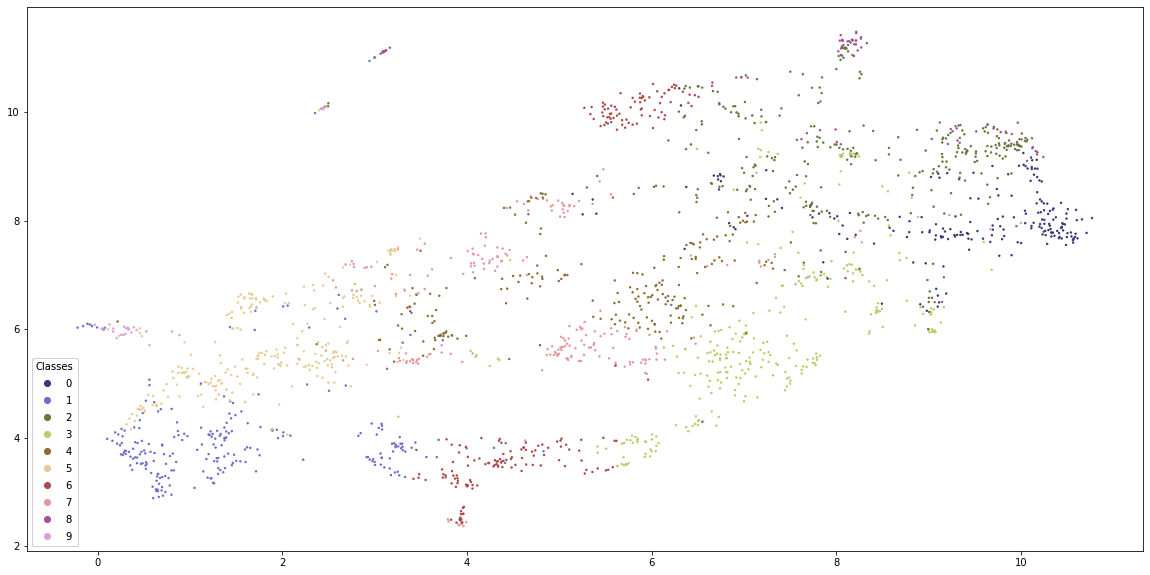

In [114]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=10),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

K-prototype visual

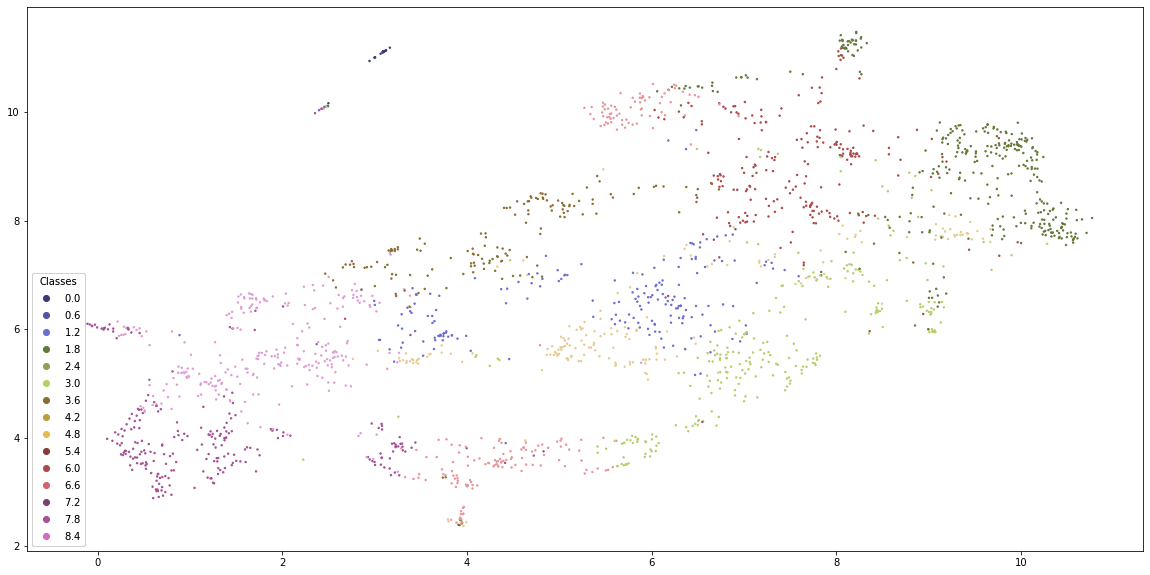

In [115]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=proto_clusters, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)


Classification evaluation

Another comparison that I'm going to do is by treating the clusters as labels and building a classification model on top. If the clusters are of high quality, the classification model will be able to predict them with high accuracy. At the same time, the models should use a variety of features to ensure that the clusters are not too simplistic. Overall, I'll check the quality by:

Distinctivness of clusters by cross-validated F1 score
The informativness of clusters by SHAP feature importances

In [116]:
#Setting the objects to category 
lgbm_data = full_data.copy()
for c in lgbm_data.select_dtypes(include='object'):
    lgbm_data[c] = lgbm_data[c].astype('category')

In [117]:
#KMeans clusters
clf_km = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_km = cross_val_score(clf_km, lgbm_data, kmeans_labels, scoring='f1_weighted')
print(f'CV F1 score for K-Means clusters is {np.mean(cv_scores_km)}')

CV F1 score for K-Means clusters is 0.8807059609050236


In [118]:
clf_km.fit(lgbm_data, kmeans_labels)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_tree=0.8,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [119]:
explainer_km = shap.TreeExplainer(clf_km)
shap_values_km = explainer_km.shap_values(lgbm_data)

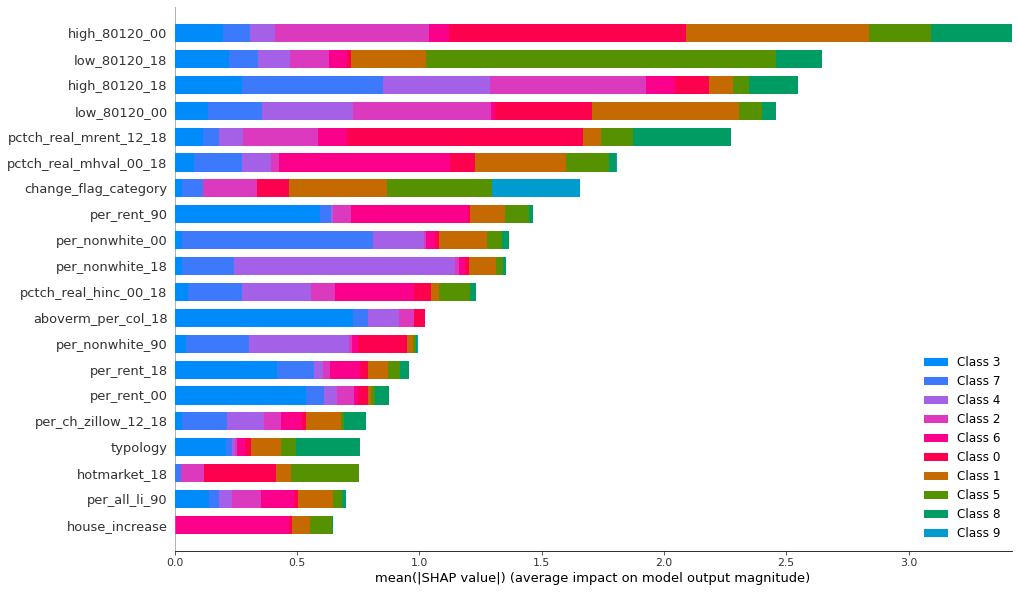

In [120]:
shap.summary_plot(shap_values_km, lgbm_data, plot_type="bar", plot_size=(15, 10))


K-Prototypes

In [121]:
clf_kp = LGBMClassifier(colsample_by_tree=0.8)
cv_scores_kp = cross_val_score(clf_kp, lgbm_data, proto_clusters, scoring='f1_weighted')
print(f'CV F1 score for K-Prototypes clusters is {np.mean(cv_scores_kp)}')

CV F1 score for K-Prototypes clusters is 0.8781091885734444


In [122]:
clf_kp.fit(lgbm_data, proto_clusters)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_by_tree=0.8,
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [123]:
explainer_kp = shap.TreeExplainer(clf_kp)
shap_values_kp = explainer_kp.shap_values(lgbm_data)

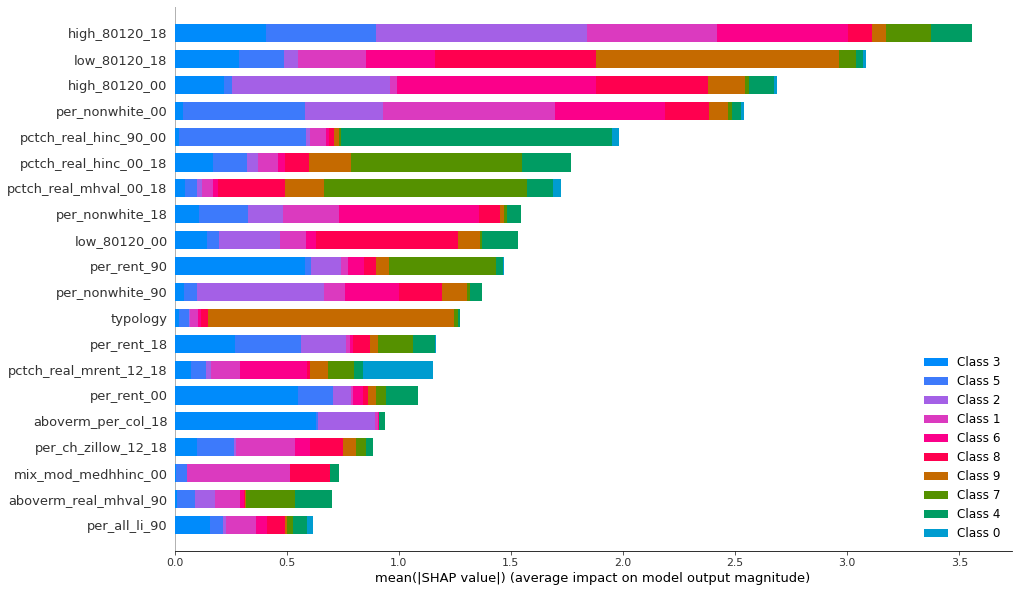

In [124]:
shap.summary_plot(shap_values_kp, lgbm_data, plot_type="bar", plot_size=(15, 10))

iii. Save the dataset as a CSV file. The first line of the CSV file should be the attribute
names as described in the previous question. 

In [125]:
#df2.to_csv("{}/data/kmodes-processed_{}".format(customized_path_to_homework, file_name))

In [126]:
#load already processed data 
#df3 = pd.read_csv("{}/data/kmodes-processed_{}".format(customized_path_to_homework, file_name), index_col=0)
#df3 = df3.astype(int)


In [127]:
"""

#Elbow method to choose the optimal number of clusters
sse = {}
for k in tqdm(range(2, 50)):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

"""

'\n\n#Elbow method to choose the optimal number of clusters\nsse = {}\nfor k in tqdm(range(2, 50)):\n    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(data)\n    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center\n\n'

In [128]:
    
fig = go.Figure(data=go.Scatter(x=list(sse.keys()), y=list(sse.values())))
fig.show()

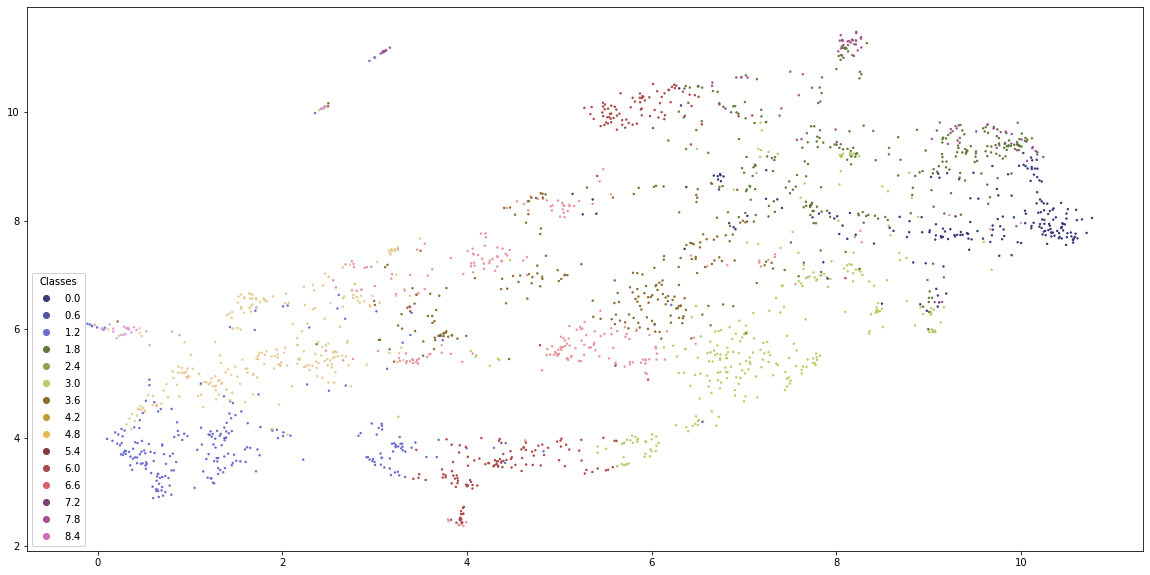

In [129]:

fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, c=kmeans_labels, cmap='tab20b', alpha=1.0)

# produce a legend with the unique colors from the scatter
legend1 = ax.legend(*scatter.legend_elements(num=15),
                    loc="lower left", title="Classes")
ax.add_artist(legend1)

In [130]:
"""
#ref: https://shap.readthedocs.io/en/latest/example_notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html
for name in full_data.columns:
    shap.dependence_plot(name, shap_values_km[1], lgbm_data, display_features=full_data)
"""

'\n#ref: https://shap.readthedocs.io/en/latest/example_notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html\nfor name in full_data.columns:\n    shap.dependence_plot(name, shap_values_km[1], lgbm_data, display_features=full_data)\n'

In [131]:
shap_values = shap_values_km
explainer = explainer_km
X_display = full_data
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][:1000,:], X_display.iloc[:1000,:])

Output hidden; open in https://colab.research.google.com to view.

Cluster visualization

In [132]:
"""
for col in all_features:
    plt.subplots(figsize = (15,5))
    sns.countplot(x='Cluster',hue=col, data = train)
    plt.show()

"""

"\nfor col in all_features:\n    plt.subplots(figsize = (15,5))\n    sns.countplot(x='Cluster',hue=col, data = train)\n    plt.show()\n\n"